In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import zarr

In [2]:
ds = zarr.open_group("/data_2/scratch/sbiegel/processed/ndvi_dataset_temporal.zarr")
params = ds["params"]
params_lower = params["params_lower"]
params_upper = params["params_upper"]
ndvi = ds["ndvi"]
ndsi = ds["ndsi"]
dates = pd.to_datetime([d.decode("utf-8") for d in ds["dates"][:]])
features = ds["features"]

T_SCALE = 1.0 / 365.0
doy = dates.dayofyear
t = torch.tensor(doy * T_SCALE, dtype=torch.float32)

def double_logistic_function(t, params):
    sos, mat_minus_sos, sen, eos_minus_sen, M, m = torch.split(torch.as_tensor(params, dtype=torch.float32), 1, dim=1)
    mat_minus_sos = torch.nn.functional.softplus(mat_minus_sos)
    eos_minus_sen = torch.nn.functional.softplus(eos_minus_sen)
    sigmoid_sos_mat = torch.sigmoid(-2 * (2 * sos + mat_minus_sos - 2 * t[:, None]) / (mat_minus_sos + 1e-10))
    sigmoid_sen_eos = torch.sigmoid(-2 * (2 * sen + eos_minus_sen - 2 * t[:, None]) / (eos_minus_sen + 1e-10))
    return (M - m) * (sigmoid_sos_mat - sigmoid_sen_eos) + m

habitat_codes = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 60, 61, 62, 63, 64, 65, 66, 612, 614, 621, 622,
    623, 624, 625, 631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643,
    651, 652, 653, 661, 662, 663, 664, 665, 60000, 60001, 65535
]
habitat_names = [
    "Water",
    "Bank & Wetland",
    "Glacier & Rock",
    "Grassland",
    "Shrubland",
    "Forest",
    "Pioneer",
    "Agriculture",
    "Urban",
    "Forest Plantation",
    "Swamp Forest",
    "Beech Forest",
    "Other Deciduous Forest",
    "Warm-Loving Pine Forest",
    "Peat-bog Forest",
    "High-altitude Coniferous Forest",
    "Riverine Salix Woodland",
    "Alder Swamp Forest",
    "Typical Beech Forest",
    "Woodruff Beech Forest",
    "Lowland Beech Forest",
    "Montane Beech Forest",
    "Subalpine Beech Forest",
    "Oak-hornbeam Forest",
    "Mixed Deciduous Forest",
    "Maple-ash-elm Forest",
    "Mixed Tilia Forest",
    "Acidophilous Oak Forest",
    "Downy-oak Forest",
    "Sweet Chestnut Forest",
    "Deciduous Alluvial Valley Forest",
    "Ravine and Scree Deciduous Forest",
    "Pine-oak Forest",
    "Pine-juniper Forest",
    "Inner-Alpine Steppe Forest",
    "Birch Bog Forest",
    "Spruce Bog Forest",
    "Spruce-alder Bog Forest",
    "Silver Fir Forest",
    "Mixed Mountain Coniferous Forest",
    "Stone-Pine Forest",
    "Low-altitude Coniferous Forest",
    "Mountain Pine Forest",
    "Single Tree, non-complex",
    "Single Tree, complex",
    "No Data / Unclassified",
]
habitat_dict = dict(zip(habitat_codes, habitat_names))

species_codes = list(range(16))
species_names = [
    "Albies alba",
    "Acer pseudoplatanus",
    "Alnus glutinosa",
    "Alnus incana",
    "Betuna pendula",
    "Castanea sativa",
    "Fagus sylvatica",
    "Fraxinus excelsior",
    "Picea abies",
    "Pinus cembra",
    "Pinus mugo arborea",
    "Pinus sylvestris",
    "Quercus petraea",
    "Quercus robur",
    "Sorbus aucuparia",
    "Other",
    "Unknown"
]

habitat = features["habitat"][:]
tree_species = features["tree_species"][:]
forest_mix_rate = features["forest_mix_rate"][:]
forest_height = features["median_forest_height"][:]
dem = features["dem"][:]
northing = features["northing"][:]
twi = features["twi"][:]

/home/sbiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


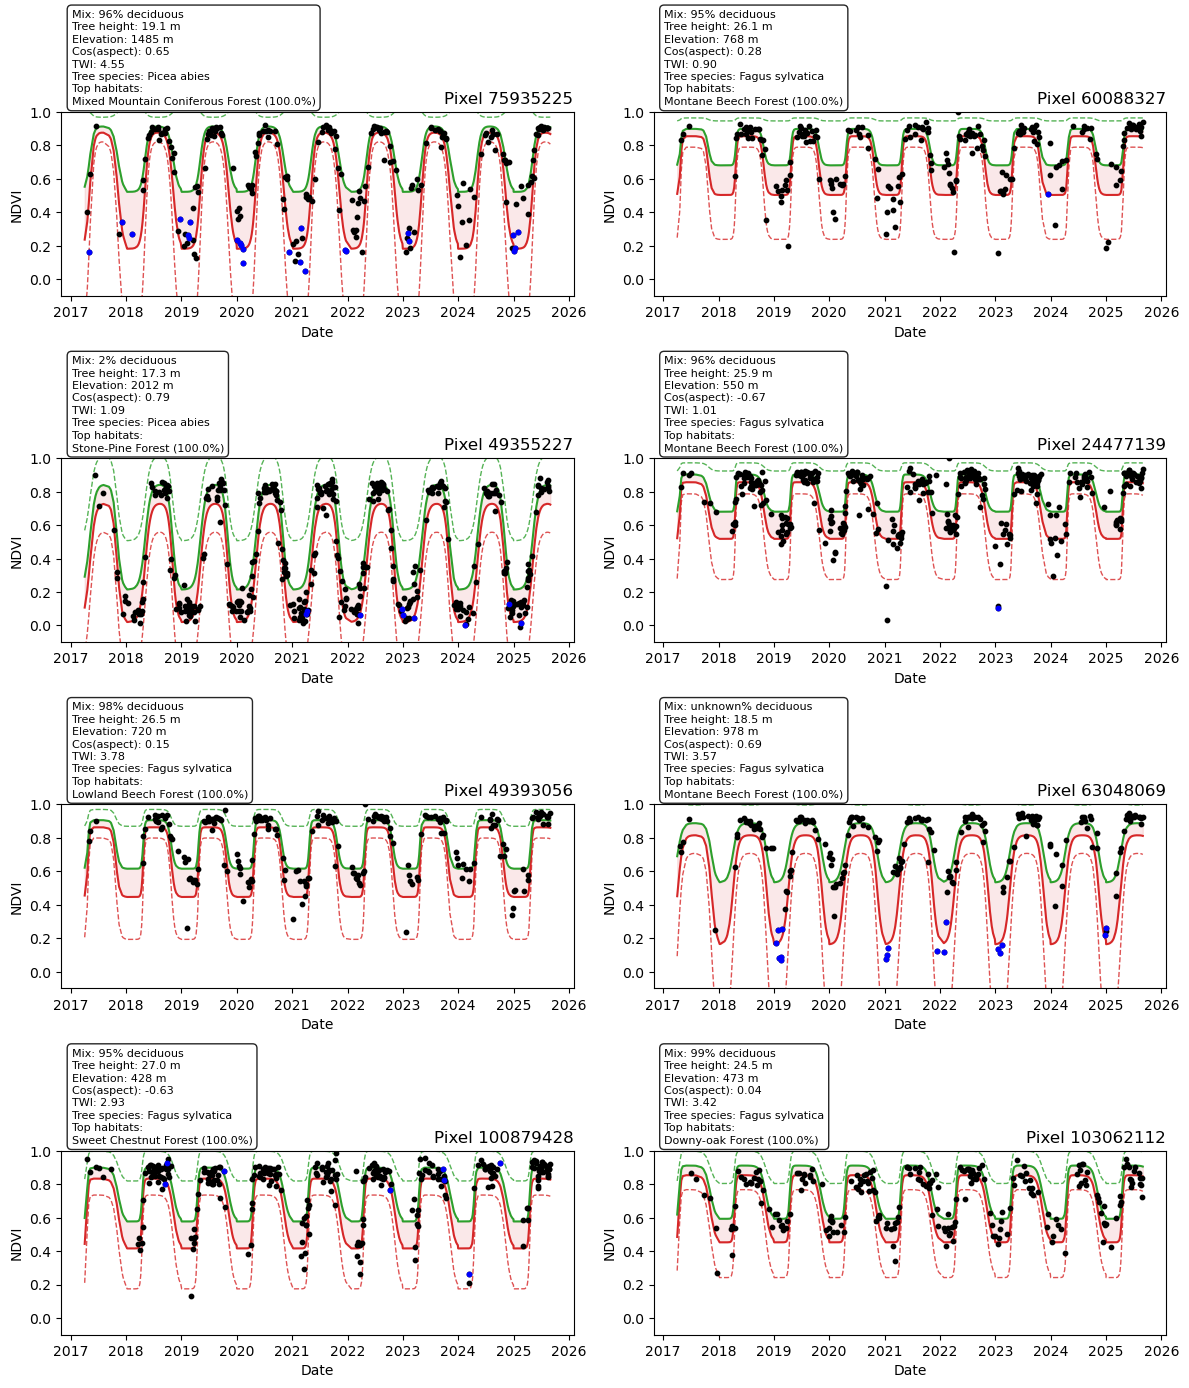

In [13]:
indices = np.random.choice(ds["params"]["params_lower"].shape[0], size=8, replace=False)
order = np.argsort(dates)
dates_sorted = np.array(dates)[order]
t_sorted = t[order]

fig, axs = plt.subplots(4, 2, figsize=(12, 14))
axs = axs.flatten()

for i, idx in enumerate(indices):
    lower = double_logistic_function(t_sorted, params_lower[[idx]]).squeeze().numpy()
    upper = double_logistic_function(t_sorted, params_upper[[idx]]).squeeze().numpy()
    ndvi_vals = np.asarray(ndvi[idx])[order]
    ndsi_vals = np.asarray(ndsi[idx])[order]
    is_snow = ndsi_vals >= 0.43

    is_valid = (ndvi_vals != -32768) & (ndvi_vals != 32767)
    ndvi_valid = ndvi_vals[is_valid] / 10000.0
    ndvi_snow = ndvi_vals[is_snow & is_valid] / 10000.0
    dates_sorted_valid = dates_sorted[is_valid]
    dates_snow = dates_sorted[is_snow & is_valid]

    iqr = np.abs(upper - lower)
    low_thr = lower - 1.5 * iqr
    high_thr = upper + 1.5 * iqr
    
    ax = axs[i]

    ax.plot(dates_sorted, high_thr, ls="--", lw=1, color="tab:green", alpha=0.8)
    ax.plot(dates_sorted, low_thr, ls="--", lw=1, color="tab:red", alpha=0.8)

    
    ax.plot(dates_sorted, lower, color="tab:red", lw=1.5)
    ax.plot(dates_sorted, upper, color="tab:green", lw=1.5)
    ax.fill_between(dates_sorted, lower, upper, color="tab:red", alpha=0.1)
    ax.scatter(dates_sorted_valid, ndvi_valid, color="black", s=10, zorder=3)
    ax.scatter(dates_snow, ndvi_snow, color="blue", s=10, zorder=4, label="Snow (NDSI ≥ 0.43)")

    mix = forest_mix_rate[idx]
    if mix == -128:
        mix = "unknown"
    hght = forest_height[idx]
    elev = dem[idx]
    north = northing[idx]
    twi_val = twi[idx]
    species = int(tree_species[idx])
    species_name = species_names[species] if species in species_codes else "Unknown"
    hab_row = habitat[idx]
    top_ids = np.argsort(hab_row)[::-1][:3]
    top_perc = hab_row[top_ids] / hab_row.sum() * 100
    nonzero_mask = top_perc > 0.1
    top_codes = [habitat_codes[j] for j in top_ids[nonzero_mask]]
    top_names = [habitat_dict[c] for c in top_codes]
    top_perc = top_perc[nonzero_mask]
    top_lines = [f"{n} ({p:.1f}%)" for n, p in zip(top_names, top_perc)]
    top_text = "\n".join(top_lines)

    text = (
        f"Mix: {mix}% deciduous\n"
        f"Tree height: {hght:.1f} m\n"
        f"Elevation: {elev:.0f} m\n"
        f"Cos(aspect): {north:.2f}\n"
        f"TWI: {twi_val:.2f}\n"
        f"Tree species: {species_name}\n"
        f"Top habitats:\n{top_text}"
    )

    ax.text(
        0.02, 1.03, text,
        transform=ax.transAxes,
        fontsize=8,
        va="bottom",
        ha="left",
        linespacing=1.3,
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.85)
    )

    ax.set_title(f"Pixel {idx}", loc="right")
    ax.set_ylim(-0.1, 1)
    ax.set_xlabel("Date")
    ax.set_ylabel("NDVI")

plt.tight_layout()
plt.show()